# Predicting Hospital Readmission

### Introduction


### Attributes
- `encounter_id`: Unique identifier of an encounter.
- `patient_nbr`: Unique identifier of a patient.
- `race`: Caucasian, Asian, African American, Hispanic, and other.
- `gender`: male, female, and unknown/invalid.
- `age`: Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100).
- `weight`: Weight in pounds.
- `admission_type_id`: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.
- `discharge_disposition_id`: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.
- `admission source_id`: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital.
- `time_in_hospital`: Integer number of days between admission and discharge.
- `payer_code`: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay.
- `medical_specialty`: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon.
- `num_lab_procedures`: Number of lab tests performed during the encounter.
- `numb_procedures`: Number of procedures (other than lab tests) performed during the encounter.
- `num_medications`: Number of distinct generic names administered during the encounter.
- `number_outpatient`: Number of outpatient visits of the patient in the year preceding the encounter.
- `number_emergency`: Number of emergency visits of the patient in the year preceding the encounter.
- `number_inpatient`: Number of inpatient visits of the patient in the year preceding the encounter.
- `diag_1`: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values.
- `diag_2`: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values.
- `diag_3`: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values.
- `number_diagnoses`: Number of diagnoses entered to the system
- `max_glu_serum`: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured.
- `A1Cresult`: Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- `change`: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”.
- `diabetesMed`: Indicates if there was any diabetic medication prescribed. Values: "yes" and "no".
- 24 features for medications: Medications under their generic names: `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `sitagliptin`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, and `metformin- pioglitazone`. The feature indicates whether the drug was prescribed or there was a change in the dosage. _Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed._
- `readmitted`: Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission


#### A note on dataset size

One problem with this dataset is that there are _a lot_ of categorical attributes - one hot encoding the dataset with minimal feature engineering results in over 2,500 columns. While this may also impact model accuracy, training models with 2500 columns and over 100,000 observations is very computationally intensive and therefore impractical. 

## Imports & Read Data

In [41]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression



%matplotlib inline

In [2]:
# # read data
# PATH_df = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\diabetic_data.csv'
# PATH_codes = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\IDs_mapping.csv'
# df = pd.read_csv(PATH_df)
# codes = pd.read_csv(PATH_codes)

In [3]:
# # read data MAC
df = pd.read_csv('Data/Raw/diabetic_data.csv')
codes = pd.read_csv('Data/Raw/IDs_mapping.csv')

## Clean Data

### codes

In [4]:
# clean ids_mapping.csv, imported as codes
codes = codes[(codes['description']!='description')] 

# merge
codes = pd.merge(codes.copy()[40:].rename(columns={'description':'admission_source_id',
                                                     'admission_type_id':'values'}),
                 (pd.merge(codes.copy()[0:8].rename(columns={'description':'admission_type_id',
                                                             'admission_type_id':'values'}),
                           codes.copy()[9:39].rename(columns={'description':'discharge_disposition_id',
                                                              'admission_type_id':'values'}),
                           how='outer',
                           left_on='values',
                           right_on='values')),
                 how='outer',
                 left_on='values',
                 right_on='values').reset_index(drop=True)

# some NAN should actually be NULL
codes.loc[15, 'admission_source_id'] = 'NULL'
codes.loc[5, 'admission_type_id'] = 'NULL'
codes.loc[16, 'discharge_disposition_id'] = 'NULL'
codes.head(10)

,values,admission_source_id,admission_type_id,discharge_disposition_id
0,1,Physician Referral,Emergency,Discharged to home
1,2,Clinic Referral,Urgent,Discharged/transferred to another short term h...
2,3,HMO Referral,Elective,Discharged/transferred to SNF
3,4,Transfer from a hospital,Newborn,Discharged/transferred to ICF
4,5,Transfer from a Skilled Nursing Facility (SNF),Not Available,Discharged/transferred to another type of inpa...
5,6,Transfer from another health care facility,NULL,Discharged/transferred to home with home healt...
6,7,Emergency Room,Trauma Center,Left AMA
7,8,Court/Law Enforcement,Not Mapped,Discharged/transferred to home under care of H...
8,9,Not Available,NaN,Admitted as an inpatient to this hospital
9,10,Transfer from critial access hospital,NaN,Neonate discharged to another hospital for neo...


### Primary df

In [5]:
# replace ? with NaN
df.replace('?', np.nan, inplace=True)

In [6]:
# drop encounter_id as it is redundant
df.drop(['encounter_id'], axis=1, inplace=True)

In [7]:
# make outcome variable binary
df['readmitted'].replace({'<30':'YES', '>30':'YES'}, inplace=True)
df.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
1,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Initial Investigation

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  numb

In [9]:
print(f'Total Values = {len(df)}\n\nUnique Values:')
for c in df.columns:
    print(f'{c}: {df[c].nunique()}')

Total Values = 101766

Unique Values:
patient_nbr: 71518
race: 5
gender: 3
age: 10
weight: 9
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 17
time_in_hospital: 14
payer_code: 17
medical_specialty: 72
num_lab_procedures: 118
num_procedures: 7
num_medications: 75
number_outpatient: 39
number_emergency: 33
number_inpatient: 21
diag_1: 716
diag_2: 748
diag_3: 789
number_diagnoses: 16
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
acetohexamide: 2
glipizide: 4
glyburide: 4
tolbutamide: 2
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
troglitazone: 2
tolazamide: 3
examide: 1
citoglipton: 1
insulin: 4
glyburide-metformin: 4
glipizide-metformin: 2
glimepiride-pioglitazone: 2
metformin-rosiglitazone: 2
metformin-pioglitazone: 2
change: 2
diabetesMed: 2
readmitted: 2


In [10]:
pd.options.display.float_format = "{:.2f}".format # two decimal places
df.drop(['patient_nbr'], axis=1).describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,2.02,3.72,5.75,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42
std,1.45,5.28,4.06,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93
min,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,1.00,1.00,1.00,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00
50%,1.00,1.00,7.00,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00
75%,3.00,4.00,7.00,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00
max,8.00,28.00,25.00,14.00,132.00,6.00,81.00,42.00,76.00,21.00,16.00


## Unique Patients

The dataset contains 101,766 observations of 71,518 patients, meaning some patients went into the hospital multiple times. Intuitively, for each of these patients, every observation except for the observation with the maximum index value (i.e., the last observation for that patient in the dataframe) is readmitted. 

Because every patient with multiple observations must have been readmitted, and because having multiple of the same patient in introduces may result in bias towards those with multiple observations, all but the first  observation is dropped for each non-unique patient.

As a result, the dataframe drops to 71,518 observations, each being a unique patient.

In [11]:
df.drop_duplicates(subset= ['patient_nbr'], keep = 'first', inplace=True)
df.drop(['patient_nbr'], axis=1, inplace=True) # becomes redundant

In [12]:
df.shape

(71518, 48)

### Missing Values

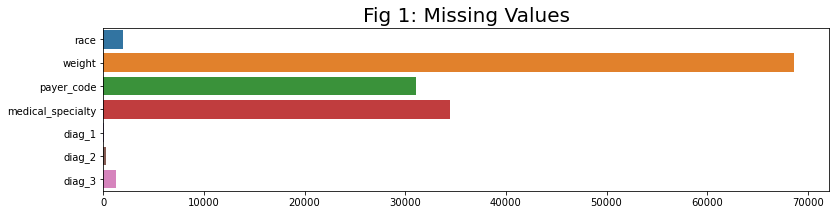

In [13]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.barplot(x=df.isnull().sum()[df.isnull().sum()>0],
            y=df.columns[df.isna().any()].tolist(),
            orient='h')

plt.title('Fig 1: Missing Values', size=20);

## Impute Missing Values

In [14]:
df.rename(columns={'diag_1':'diagnosis'}, inplace=True)

In [15]:
max_race = df['race'].value_counts().idxmax()
max_diag = df['diagnosis'].value_counts().idxmax()

for i in tqdm(df.index):
    current_race = df.at[i, 'race']
    current_diag = df.at[i, 'diagnosis']
    
    if pd.isnull(current_race) == True:
        df.at[i, 'race'] = max_race

    if pd.isnull(current_diag) == True:
        df.at[i, 'diagnosis'] = max_diag

100%|██████████| 71518/71518 [00:00<00:00, 127076.75it/s]


#### Drop Columns

Over 90% of `weight` is missing, so it is dropped from the dataset. `payer_code`, `medical_specialty` are both dropped as nearly 50% are missing. 

`diag_2` and `diag_3` are dropped as `diag_1` is already included and they are categorical variables with many unique values, drastically increasing the size of the one hot encoded dataframe. 

Various drug attributes are dropped as well. This is because these attributes have no variation.

In [16]:
for c in df.columns:
    if df[c].value_counts().nunique()<2:
        print(c)

examide
citoglipton
glimepiride-pioglitazone


In [17]:
cols_to_drop = ['weight',
                'payer_code',
                'medical_specialty',
                'diag_2',
                'diag_3',
                'examide',
                'glimepiride-pioglitazone',
                'citoglipton'] # ,
#                 'metformin-pioglitazone',
#                 'metformin-rosiglitazone',
#                 'tolazamide',
#                 'troglitazone',
#                 'miglitol',
#                 'acarbose',
#                 'acetohexamide',
#                 'chlorpropamide',
#                 'glipizide-metformin']

df.drop(cols_to_drop, axis=1, inplace=True)

## Categorization of Diagnoses

There are hundreds of different diagnoses here. The broad categories are available [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). 

In [18]:
for i in df.index:
    d = df.at[i, 'diagnosis']
    
    try:
        d = float(df.at[i, 'diagnosis'])
        
    except ValueError:
        df.at[i, 'diagnosis'] = 'other'
    
    else:
        if d>=1 and d<=139:
            df.at[i, 'diagnosis'] = 'infections/parasitic'
        elif d>=140 and d<=239:
            df.at[i, 'diagnosis'] = 'neoplasms'
        elif d>=240 and d<=279:
            df.at[i, 'diagnosis'] = 'endocrine/nutrition/immunity'
        elif d>= 280 and d<=289:
            df.at[i, 'diagnosis'] = 'blood'
        elif d>=290 and d<=319:
            df.at[i, 'diagnosis'] = 'mental disorders'
        elif d>=320 and d<=329:
            df.at[i, 'diagnosis'] = 'nervous system'
        elif d>=390 and d<=459:
            df.at[i, 'diagnosis'] = 'circulatory'
        elif d>=460 and d<=519:
            df.at[i, 'diagnosis'] = 'respiratory'
        elif d>=520 and d<=579:
            df.at[i, 'diagnosis'] = 'digestive'
        elif d>=580 and d<=629:
            df.at[i, 'diagnosis'] = 'genitourinary'
        elif d>=630 and d<=679:
            df.at[i, 'diagnosis'] = 'pregnancy/childbirth'
        elif d>=680 and d<=709:
            df.at[i, 'diagnosis'] = 'skin/subcutaneous tissue'
        elif d>=710 and d<=739:
            df.at[i, 'diagnosis'] = 'musculoskeletal'
        elif d>=740 and d<=759:
            df.at[i, 'diagnosis'] = 'congenital anomalies'
        elif d>=760 and d<=779:
            df.at[i, 'diagnosis'] = 'perinatal'
        elif d>=780 and d<=799:
            df.at[i, 'diagnosis'] = 'ill-defined'
        else:
            df.at[i, 'diagnosis'] = 'injury/poisoning'

## Exploratory Analysis

### Readmitted - Variable of Interest

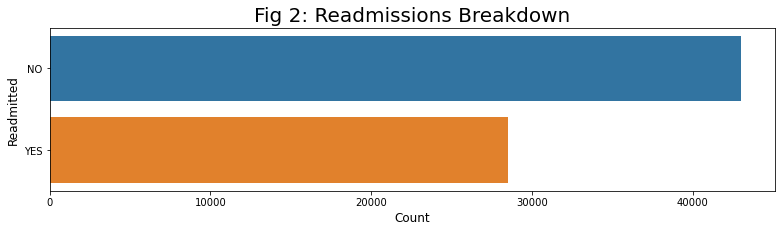

In [19]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.countplot(y='readmitted', data=df)
plt.title('Fig 2: Readmissions Breakdown', size=20)
plt.xlabel('Count', size=12)
plt.ylabel('Readmitted', size=12);

### Non-Drug Features vs. Readmission (Non-Drugs)

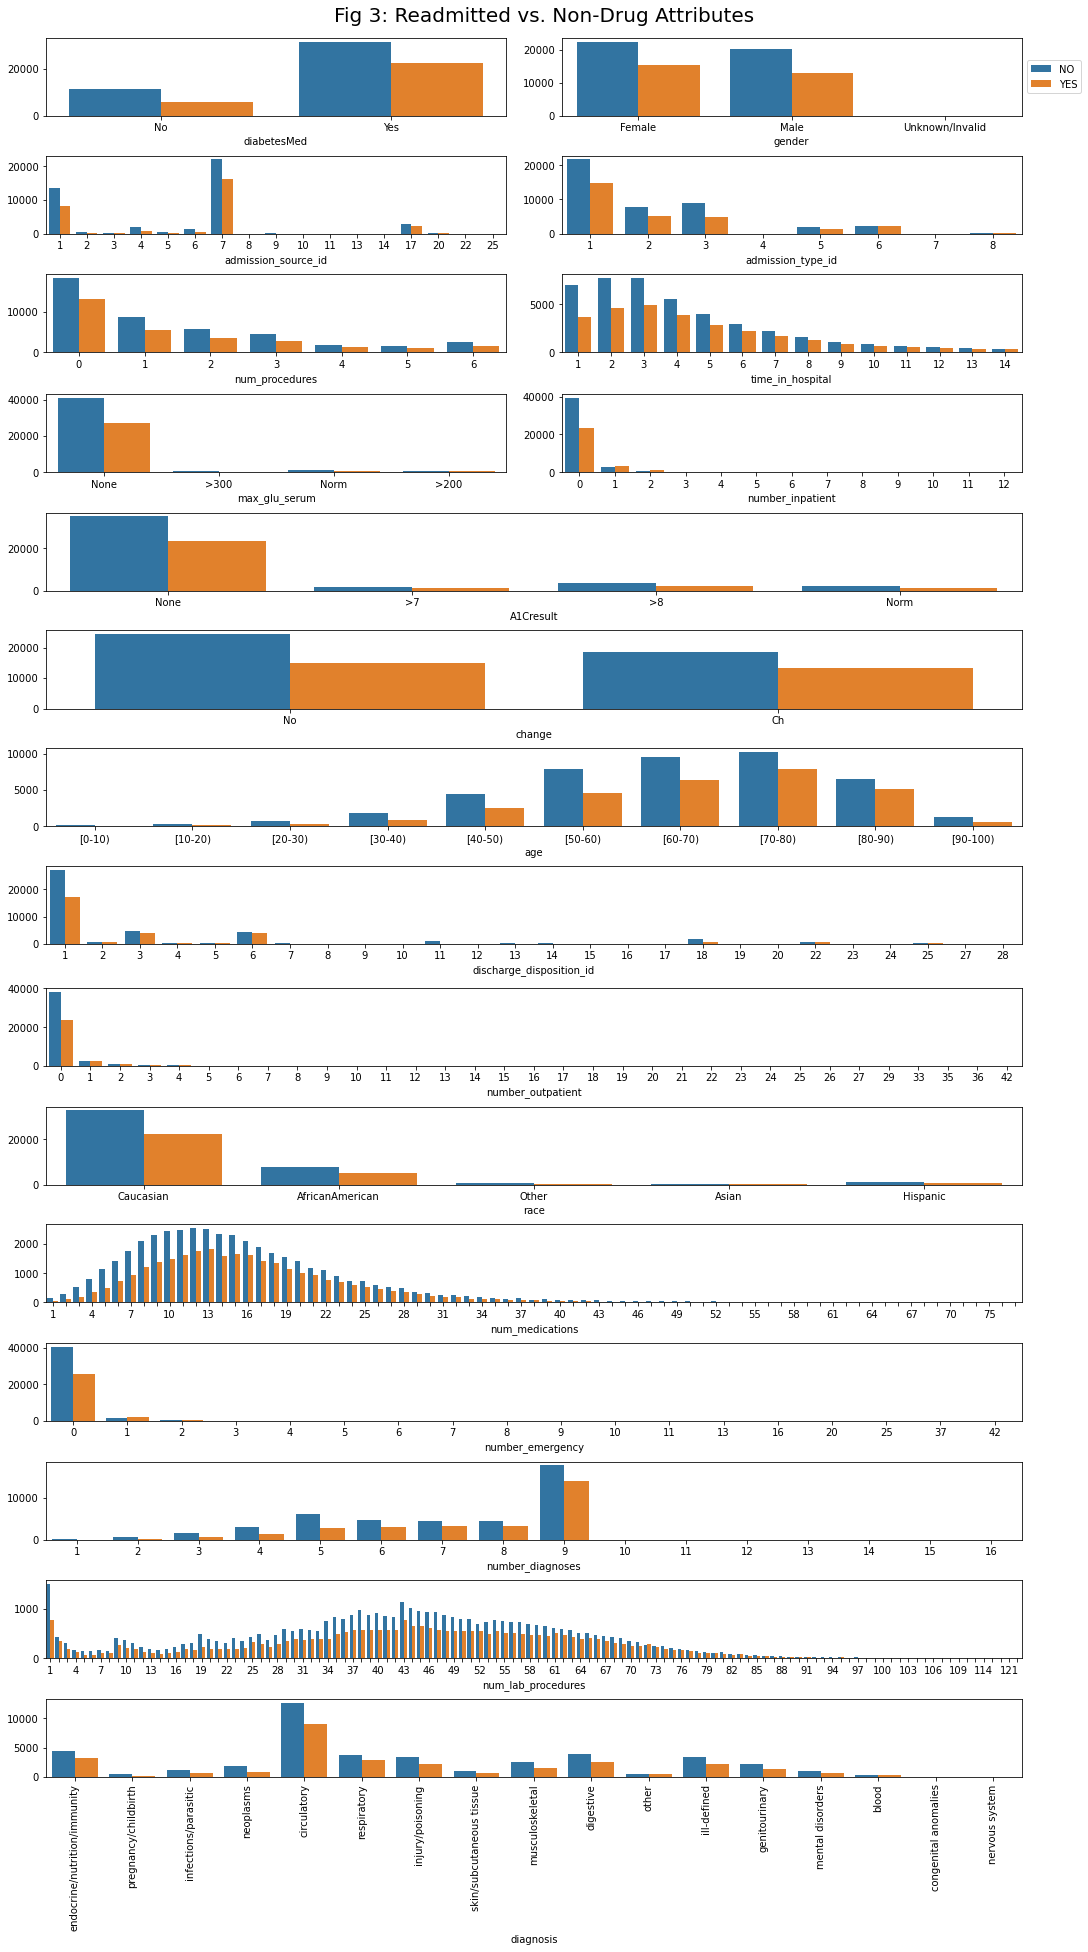

In [20]:
columns = ['gender',
           'diabetesMed',
           'admission_type_id',
           'admission_source_id',
           'time_in_hospital',
           'num_procedures',
           'number_inpatient',
           'max_glu_serum',
           'A1Cresult',
           'change',
           'age',
           'discharge_disposition_id',
           'number_outpatient',
           'race',           
           'num_medications',
           'number_emergency',
           'number_diagnoses',
           'num_lab_procedures',
           'diagnosis']

def print_countplots(fig, columns, hue=df['readmitted'], tight=[], df=df, col_pos=0):
    for i, ax in enumerate(fig.axes):
        sns.countplot(x=df[columns[col_pos]], hue=hue, ax=ax)
        ax.get_legend().remove()
        ax.set_ylabel('')

        if df[columns[col_pos]].name == 'diagnosis':
            _ = plt.xticks(rotation=90)
            
        if df[columns[col_pos]].name in tight:
            n=3
            [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
            
        if ax == ax0:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        col_pos += 1

fig = plt.figure(constrained_layout=True, figsize=(15, 27))
gs = GridSpec(15, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, :])
ax5 = fig.add_subplot(gs[5, :])
ax6 = fig.add_subplot(gs[6, :])
ax7 = fig.add_subplot(gs[7, :])
ax8 = fig.add_subplot(gs[8, :])
ax9 = fig.add_subplot(gs[9, :])
ax10 = fig.add_subplot(gs[10, :])
ax11 = fig.add_subplot(gs[11, :])
ax12 = fig.add_subplot(gs[12, :])
ax13 = fig.add_subplot(gs[13, :])
ax14 = fig.add_subplot(gs[14, :])


print_countplots(fig=fig, columns=columns, tight=['num_medications',
                                                  'num_lab_procedures'])
fig.suptitle("Fig 3: Readmitted vs. Non-Drug Attributes", size=20);

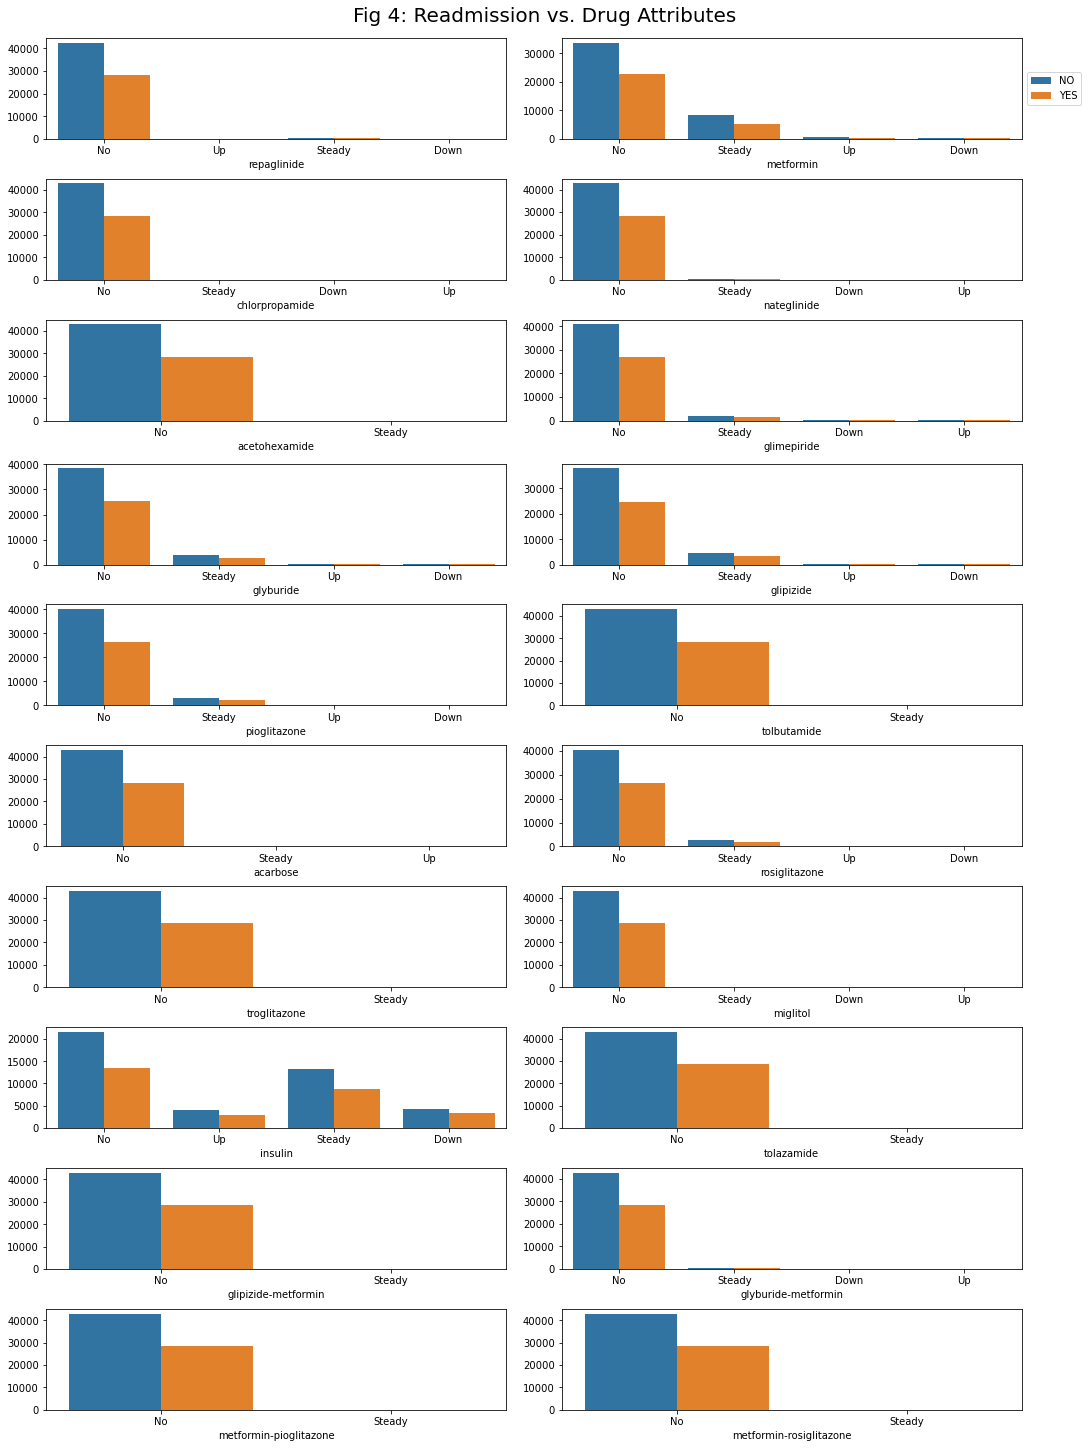

In [21]:
drug_cols = [col for col in df.columns.drop(['readmitted']) if col not in columns]

fig = plt.figure(constrained_layout=True, figsize=(15, 20))
gs = GridSpec(10, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, 1:])
ax4_ = fig.add_subplot(gs[4, :1])
ax5 = fig.add_subplot(gs[5, 1:])
ax5_ = fig.add_subplot(gs[5, :1])
ax6 = fig.add_subplot(gs[6, 1:])
ax6_ = fig.add_subplot(gs[6, :1])
ax7 = fig.add_subplot(gs[7, 1:])
ax7_ = fig.add_subplot(gs[7, :1])
ax8 = fig.add_subplot(gs[8, 1:])
ax8_ = fig.add_subplot(gs[8, :1])
ax9 = fig.add_subplot(gs[9, 1:])
ax9_ = fig.add_subplot(gs[9, :1])

print_countplots(fig=fig,
                 columns=drug_cols,
                 hue=df['readmitted'])
fig.suptitle("Fig 4: Readmission vs. Drug Attributes", size=20);

# Feature Engineering
## Drugs

In an effort to reduce dimensionality, changes in prescribed drug dosages are used instead. A composite metric, `drug_changes` is created. For each prescribed change in the dosage of a drug, whether it be increased or decreased, this metric increases by 1. Otherwise, it is not increased (i.e., someone with no changes in their prescribed drug dosages would have a `drug_changes` of 0).

In [22]:
df['drug_changes'] = 0

for i in tqdm(df.index):
    for c in drug_cols:
        if df.at[i, c] == 'Up':
            df.at[i, 'drug_changes'] = df.at[i, 'drug_changes'] + 1
        elif df.at[i, c] == 'Down':
            df.at[i, 'drug_changes'] = df.at[i, 'drug_changes'] + 1

100%|██████████| 71518/71518 [00:09<00:00, 7686.44it/s]


In [23]:
# drop drug columns
df.drop(drug_cols, axis=1, inplace=True)

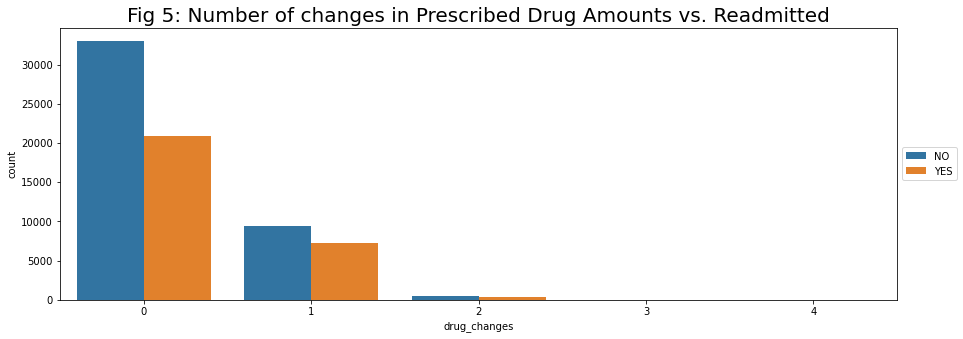

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x=df['drug_changes'], hue=df['readmitted'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig 5: Number of changes in Prescribed Drug Amounts vs. Readmitted', size=20);

In [25]:
for i in tqdm(df.index):
    current_admin_source = df.at[i, 'admission_source_id']
    current_admin_type = df.at[i, 'admission_type_id']
    current_dis = df.at[i, 'discharge_disposition_id']
    
    # admission_source_id
    if current_admin_source in [2, 3]: # lump all referalls
        df.at[i, 'admission_source_id'] = 1 
    
    elif current_admin_source in [5, 6, 10, 18, 19, 22, 25, 26]: # lump all transfers and the one readmission from 
        df.at[i, 'admission_source_id'] = 4                      # the same health agency
        
    elif current_admin_source in [12, 14, 23, 24]: # lump all baby deliveries
        df.at[i, 'admission_source_id'] = 11
        
    elif current_admin_source in [15, 17, 20, 21]: # lump all not available, not mapped, unknown, and NULL
        df.at[i, 'admission_source_id'] = 9 
    
    
    # admission_type_id
    if current_admin_type in [6, 8]: # lump all not available, unknown, NULL
        df.at[i, 'admission_type_id'] = 5
    
    elif current_admin_type in [2, 7]: # lump emergency, urgent care, and trauma center
        df.at[i, 'admission_type_id'] = 1 
    
    
    # discharge_disposition_id
    if current_dis == 5: # lump discharged to home and discharged to home with home health agency
        df.at[i, 'discharge_disposition_id'] = 1 
        
    elif current_dis in [3, 4, 5, 6, 8, 10, 15, 17, 22, 23, 24, 16, 30, 27, 28, 29]: # lump discharged to another facility
        df.at[i, 'discharge_disposition_id'] = 2
        
    elif current_dis in [19, 20, 21]: # lump expired patients
        df.at[i, 'discharge_disposition_id'] = 11 
        
    elif current_dis == 13: # lump both hospice
        df.at[i, 'discharge_disposition_id'] = 14 
        
    elif current_dis in [25, 26]: # lump Null, unknown, etc
        df.at[i, 'discharge_disposition_id'] = 18

100%|██████████| 71518/71518 [00:01<00:00, 43569.02it/s]


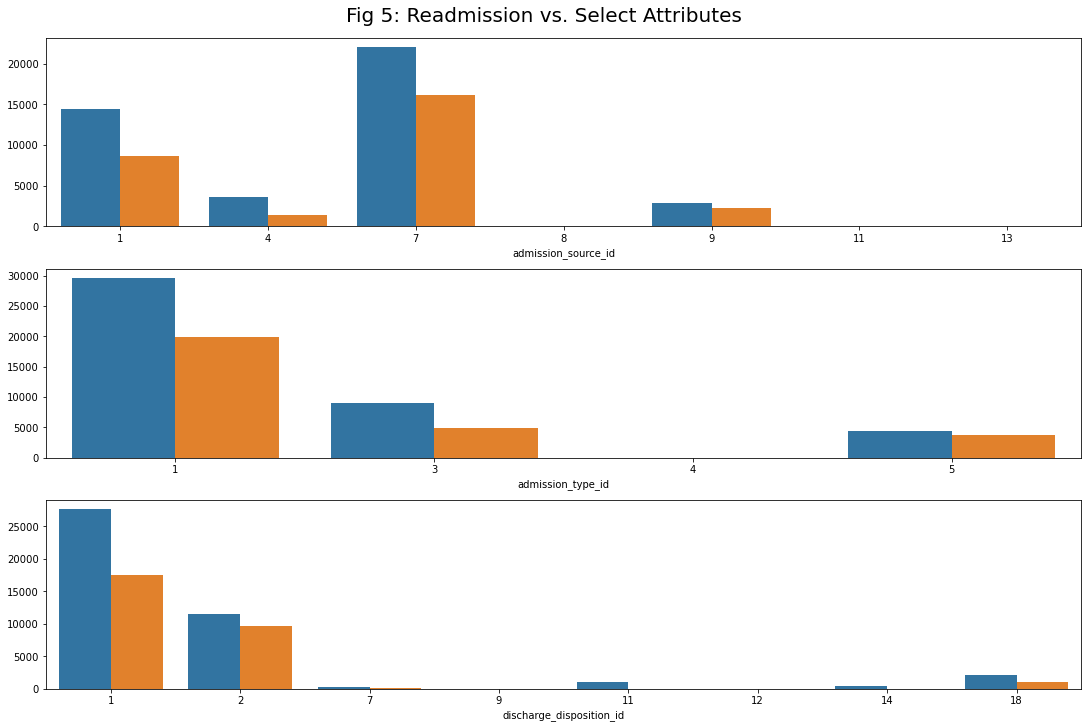

In [26]:
columns = ['admission_source_id', 'admission_type_id', 'discharge_disposition_id']

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])

print_countplots(fig=fig,
                 columns=columns,
                 hue=df['readmitted'])
fig.suptitle("Fig 5: Readmission vs. Select Attributes", size=20);

# Encode Categorical Attributes

In [27]:
# find categorical and continuous columns
continuous_cols = []
categorical_cols = []
for c in df.columns:
    if df[c].dtype=='int64':
        if 'id' not in c:
            continuous_cols.append(c)
        else:
            categorical_cols.append(c)
    else:
        categorical_cols.append(c)

In [28]:
df_ohe = pd.get_dummies(data=df, columns=categorical_cols, drop_first=True)

In [29]:
df_ohe.shape

(71518, 65)

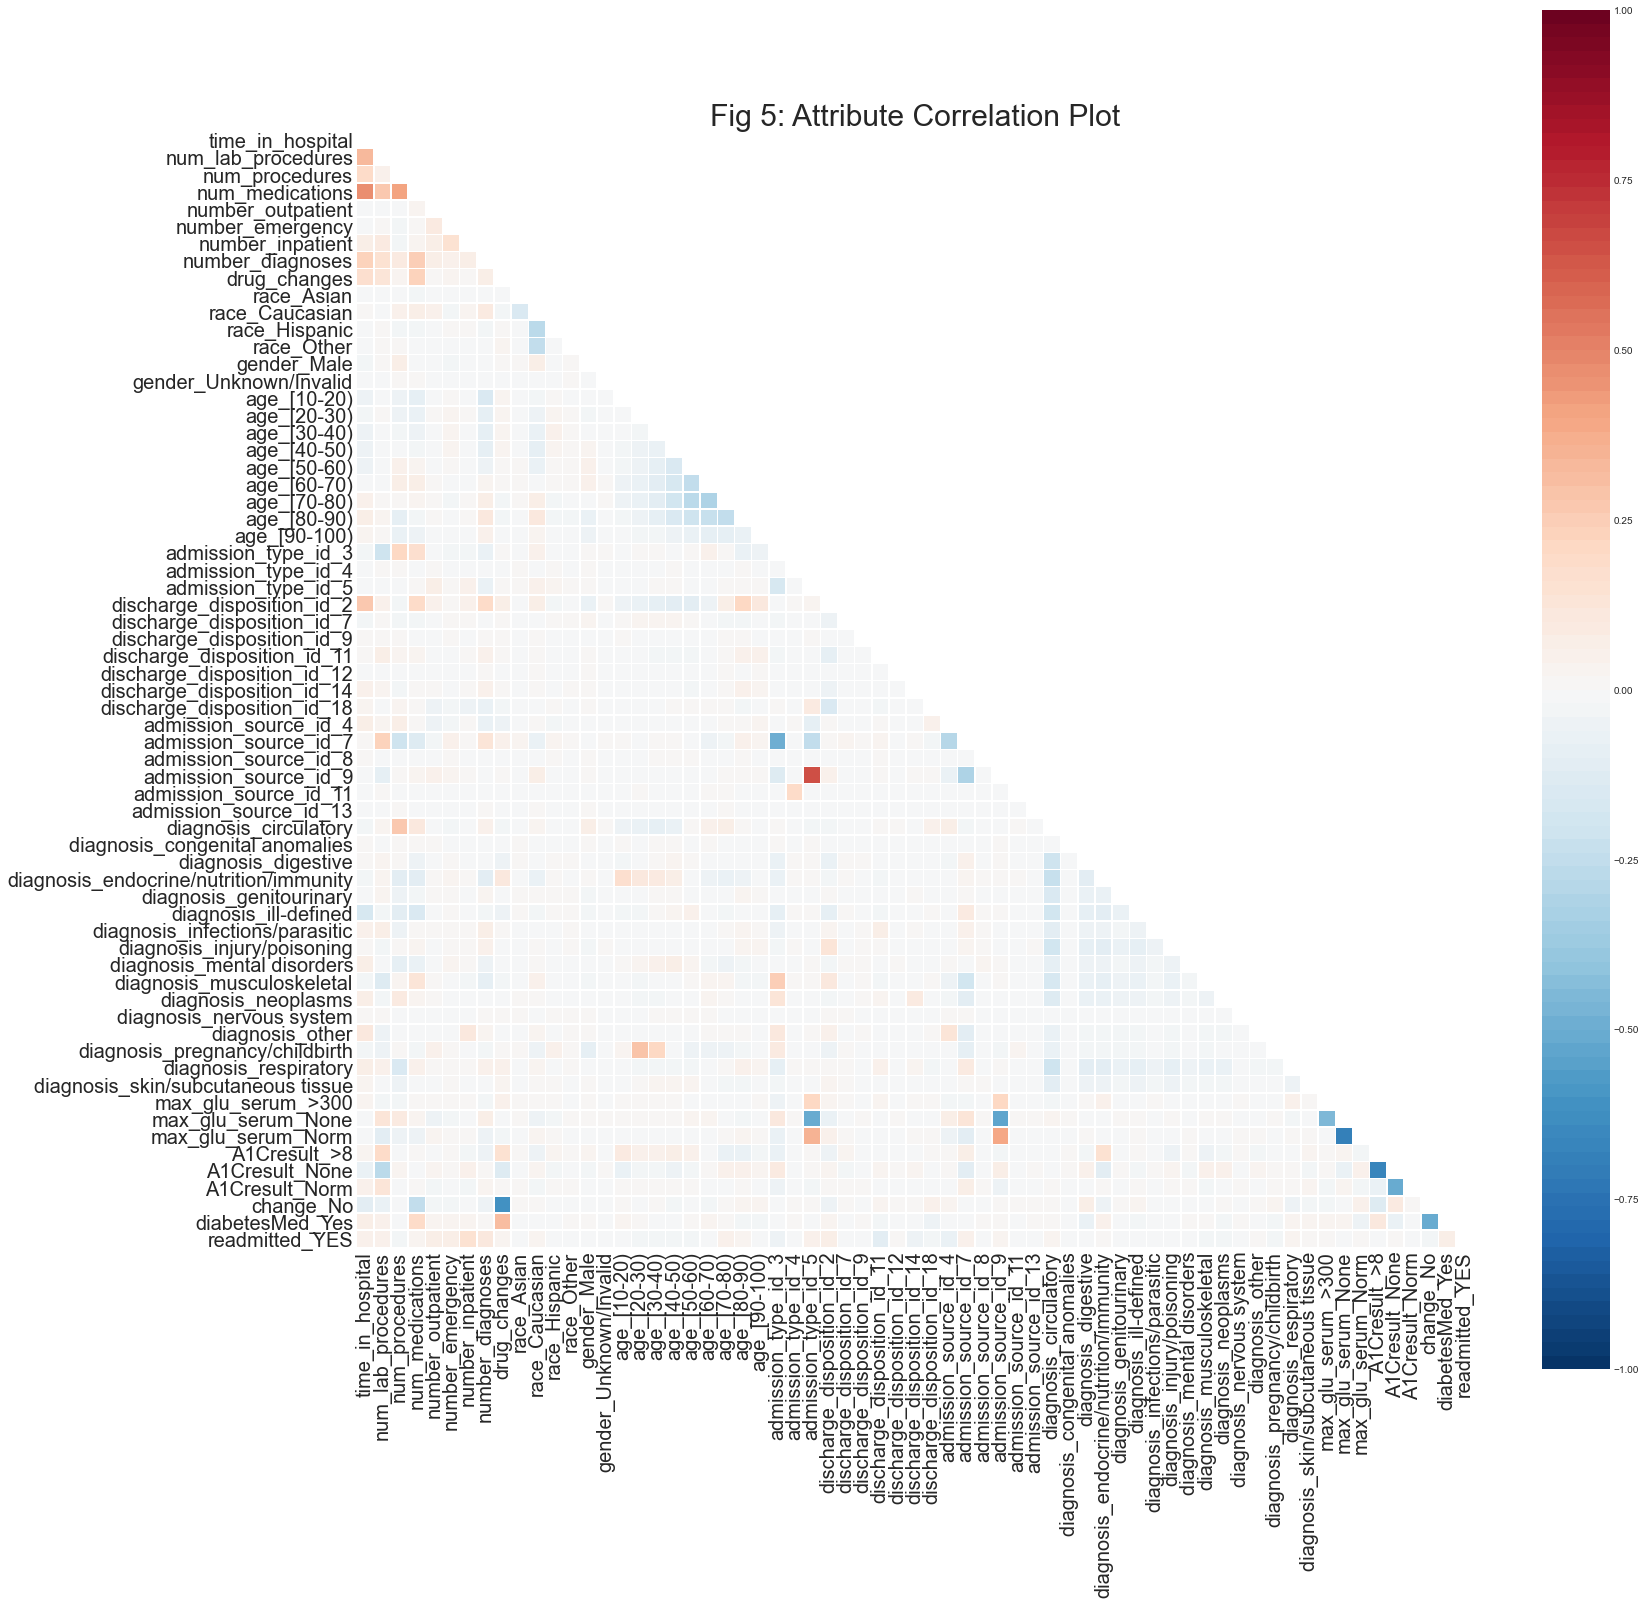

In [30]:
def corr_plot(df, title, figsize=(25, 25), max_cols=20):
    """
    Prints correlation plot. If number of columns > max_cols then annotations are turned off. 
    """
  
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=figsize)
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # if too many columns, plot gets messy because of in-box annotations
    if len(df.columns)>max_cols:
        annot = False
    else:
        annot = True   
    
    sns.heatmap(df.corr(),
                annot=annot,
                vmin=-1, vmax=1,
                square=True, 
                cmap=sns.color_palette('RdBu_r', 100),
                mask=mask,
                linewidths=0.5)
    # title
    plt.title(title, size=30)
    
    plt.xticks(size=20)
    plt.yticks(size=20)

corr_plot(df_ohe, title='Fig 5: Attribute Correlation Plot')

In [31]:
# import plotly.figure_factory as ff

# fig = ff.create_annotated_heatmap(df_ohe.corr().values.tolist())
# fig.show()

In [32]:
# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')

# heatmap = hv.HeatMap(df_ohe.corr()).sort()

# heatmap.opts(opts.HeatMap(tools=['hover'], colorbar=True, width=325, toolbar='above', clim=(-2, 2)))


# Splitting - Train & Test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(['readmitted_YES'], axis=1), 
                                                    df_ohe['readmitted_YES'],
                                                    train_size=.75,
                                                    shuffle=True,
                                                    random_state=1)

# Scaling

In [34]:
ct = ColumnTransformer(transformers=[('scaler', StandardScaler(), continuous_cols)],
                       remainder='passthrough')

In [35]:
X_train = pd.DataFrame(ct.fit_transform(X_train),
                       columns=X_train.columns)
X_train.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,drug_changes,race_Asian,...,diagnosis_respiratory,diagnosis_skin/subcutaneous tissue,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes
0,-0.78,-0.86,0.90,1.84,-0.26,-0.20,-0.29,-1.12,-0.55,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1,-0.78,1.20,-0.81,-0.56,-0.26,-0.20,-0.29,0.88,-0.55,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00
2,-0.10,0.85,0.90,1.84,-0.26,-0.20,-0.29,0.88,1.55,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
3,2.28,-0.11,2.03,1.48,2.49,-0.20,-0.29,0.88,1.55,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
4,0.24,-0.26,0.90,0.76,-0.26,-0.20,-0.29,0.88,-0.55,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


# Model Training & Hyperparameter Optimization

- SVMs - bad option.

In [36]:
# setup
scores = {} # create empty dict to store models and cross validation best scores

def results(estimator):
    """
    1. Adds fitted model and best score from RandomizedSearchCV to scores dictionary.
    2. Prints fitted model best parameters and best score
    """
    scores[estimator] = estimator.best_score_ # add fitted model and .best_score_ to models dictionary
    return print(f'Best params: {estimator.best_params_}'+f'\nBest estimator score: {estimator.best_score_}')

## Logistic Regression

In [58]:
# ridge regularization
p = {'C':np.arange(1, 16, 2),
     'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':[None, 'balanced']}
ridge = GridSearchCV(LogisticRegression(penalty='l2'),
                           param_grid=p,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           scoring='accuracy')
ridge.fit(X_train, y_train)
results(ridge)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.8min finished


Best params: {'C': 9, 'class_weight': None, 'solver': 'newton-cg'}
Best estimator score: 0.6323501292013913


In [38]:
# lasso regularization
p = {'C':np.arange(1, 20, 2),
     'solver':['liblinear', 'saga']}
lasso = RandomizedSearchCV(LogisticRegression(penalty='l1'),
                           param_distributions=p,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           scoring='accuracy')
lasso.fit(X_train, y_train)
results(lasso)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.9s finished


Best params: {'solver': 'liblinear', 'C': 7}
Best estimator score: 0.6322755579858805


## Stochastic Gradient Descent (SGD) Classifier

In [57]:
from sklearn.linear_model import SGDClassifier

p = {'alpha':np.linspace(0.000001, 1, 5),
     'penalty':['l1', 'l2'],
     'loss':['hinge', 'log', 'squared_loss', 'huber'],
     'epsilon':np.linspace(0.01, 5, 5)}
sgd = GridSearchCV(SGDClassifier(),
                   param_grid=p,
                   n_jobs=-1,
                   cv=5, 
                   verbose=1,
                   scoring='accuracy')
sgd.fit(X_train, y_train)
results(sgd)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


Best params: {'alpha': 0.25000075, 'epsilon': 1.2575, 'loss': 'huber', 'penalty': 'l2'}
Best estimator score: 0.6228046521260096


## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

# random forest
p = {'n_estimators':np.linspace(10, 300, 15).astype(int),
     'bootstrap':[True, False],
     'max_depth':[None, 50, 55, 58, 60, 62, 65, 67, 70, 72, 75],
     'min_samples_split':np.linspace(2, 25, 10).astype(int),
     'min_samples_leaf':np.linspace(2, 100, 10).astype(int),
     'max_features':['auto', 'log2']}

randomforest = RandomizedSearchCV(RandomForestClassifier(),
                                  param_distributions=p,
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=1,
                                  scoring='accuracy')
randomforest.fit(X_train, y_train)
results(randomforest)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Best params: {'n_estimators': 134, 'min_samples_split': 22, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Best estimator score: 0.6379619746585778


## Ensembles

In [97]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

p = {'loss':['deviance', 'exponential'],
     'learning_rate':np.linspace(0.01, 1, 20),
     'n_estimators':np.linspace(50, 150, 30).astype(int),
     'subsample':np.linspace(0.1, 1, 20),
     'min_samples_split':np.linspace(0.1, 1, 10),
     'min_samples_leaf':[1, 0.0, 0.1, 0.2, 0.3, 0.4],
     'max_depth':np.linspace(1, 100, 2).astype(int),
     'min_weight_fraction_leaf':np.linspace(0.1, 1, 10)}

gb = RandomizedSearchCV(GradientBoostingClassifier(), 
                        param_distributions=p,
                        cv=5,
                        n_jobs=-1,
                        verbose=1,
                        scoring='accuracy')
gb.fit(X_train, y_train)
results(gb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


Best params: {'subsample': 0.7157894736842105, 'n_estimators': 87, 'min_weight_fraction_leaf': 0.4, 'min_samples_split': 1.0, 'min_samples_leaf': 0.3, 'max_depth': 1, 'loss': 'exponential', 'learning_rate': 0.06210526315789474}
Best estimator score: 0.6010664093970159


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# adaboost
p = {'n_estimators':np.arange(20, 150, 2),
     'learning_rate':np.linspace(0.1, 1, 20)} # ,
#      'algorithm':randomforest.best_estimator_}

adb = RandomizedSearchCV(AdaBoostClassifier(),
                         param_distributions=p,
                         cv=5,
                         verbose=1,
                         n_jobs=-1,
                         scoring='accuracy')
adb.fit(X_train, y_train)
results(adb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.2s


In [ ]:
# # elastic net
# params = {'C':list(range(1, 10)), 
#           'l1_ratio':list(np.linspace(0, 1, 11))
#          }

# elasticnet = RandomizedSearchCV(LogisticRegression(penalty='elasticnet', solver='saga'),
#                           param_distributions=params, n_jobs=-1, cv=5, verbose=1)
# elasticnet.fit(X_train, y_train)
# print(elasticnet.best_params_, elasticnet.best_score_)